## Final Project Submission

Please fill out:
* Student name: Jessica Forrest-Baldini
* Student pace: Part-time
* Scheduled project review date/time: 
* Instructor name: 
* Blog post URL:


## Import Packages & Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
from datetime import datetime as date
import matplotlib.pyplot as plt
%matplotlib inline

data = pd.read_csv('kc_house_data.csv') 
df = pd.DataFrame(data)
#df.head()

## Clean Data

In [2]:
# Drop yr_renovated - only 744 homes renovated
# Drop waterfront - only 146 homes with waterfronts
# Drop view - this represent if the property has been viewed
# Drop id
# Drop zipcode for now until I learn how to effectively utilize its data

to_drop = ['yr_renovated','waterfront','view','id'] # ,'zipcode'
df = df.drop(to_drop, axis=1)

In [3]:
# Replace NaN basement values with 0 as there are only 454 of them 
# Test median values for these later to see if it improves model

df.sqft_basement = df.sqft_basement.replace('?','0.0').astype(float)
#df.sqft_basement = df.sqft_basement+1

In [4]:
# Take abs of longitude for normalization later on
df.long = abs(df.long)

8317


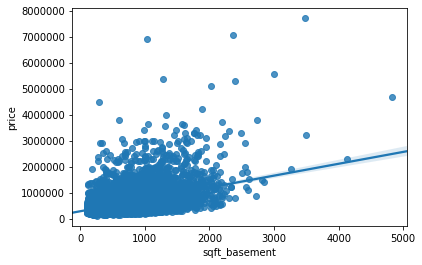

In [5]:
#print(df.sqft_basement.describe())
#df.sqft_basement.value_counts()
#df[df.sqft_basement > 100].sort_values(by='sqft_basement', ascending=True).head(20)
print(sum(df.sqft_basement > 0))
#sns.regplot(df.sqft_basement,df.price);
sns.regplot(df[df.sqft_basement >= 110].sqft_basement,df[df.sqft_basement >= 110].price);

Only 8,317 of the 32,000+ homes have basements, so we're going to bin them. I used zero as one bin and then did a quartile split for all the 'sqft_basement' values for homes with basements. 

In [6]:
# # Bin 'sqft_basement' starting at the min square footage for homes with a basement
# bins = pd.qcut(df.sqft_basement[df.sqft_basement >= 110],q=4)
# bins.value_counts()

In [7]:
# Bin sqft_basement

bins_sqft_basement = [0,109,450,980,5000]

# Bin data & return dummies
def binned_dummies(data, features, bins):
    data_bins = pd.cut(data, bins)
    data_bins = data_bins.cat.as_unordered()
    dummies = pd.get_dummies(data_bins, prefix = features, drop_first=True)
    return dummies

dummies_sqft_basement = binned_dummies(df.sqft_basement,'sqft_basement', bins_sqft_basement)

# Remove original column from data set
df = df.drop(['sqft_basement'], axis=1)
                                            
# Add new columns in
df = pd.concat([df, dummies_sqft_basement], axis=1)

In [8]:
# plt.hist(df.grade);

In [9]:
# plt.hist(df.condition);

In [10]:
# df.condition.describe()

In [11]:
# plt.hist(df.long);

In [12]:
# Define function to convert datestr to datenum
def datenum(datestr):
    '''
    Convert datestring in the format MM/DD/YYYY
    to MATLAB style datenum
    '''
    datenum = date.toordinal(date((int(datestr.split('/', -1)[2])),
                                  (int(datestr.split('/', -1)[0])),
                                  (int(datestr.split('/', -1)[1]))
                                 ))+366
    return datenum

# Apply to date column
df.date = df.date.map(datenum)

Explore the data and check for any outliers.

In [13]:
# round(df.describe(),1)

We can see here that bedrooms has what seems to be a major outlier, 33 bedrooms. Let's take a deeper look. 

In [14]:
# # Compare with other homes in data set that have high number of bedrooms
# df[df.bedrooms > 9] 

In [15]:
# 33 bedrooms and only 1.75 bathrooms doesn't seem right. It is a pretty big lot at 6,000sqft
# but 33 bedrooms doesn't seem right. Remove. 

to_drop = df[df.bedrooms == 33].index
df = df.drop(to_drop)

'sqft_lot' seems to have a major outlier at 1,651,359 sqft. Let's take a closer look.

In [16]:
# print(df.sqft_lot.median())
# display(df.sort_values(by='sqft_lot', ascending=False).head(5))

This appears to be the highest, but not necessarily an outlier. Let's go ahead and leave it for now. 

In [17]:
# df.long.describe()

In [18]:
# plt.hist(df.long);

## Normalize, MinMax Scale, Standardize, 
One-Hot Encode

First, check for normality, heteroscedasticity & discover categorical data. Can get a good idea of categorical features from looking at the data above, but let's explore normality, categorical and any relationships using a pairplot.

In [19]:
# Commented out because takes a long time to run
#sns.pairplot(df)

While 'condition' and 'grade' are technically categorical, they are on a scale, so I am going to leave them as is, and will min-max scale them. 

In [20]:
# Normalize Data

# Log Transform 

# Continuous variables
features = ['date','price','sqft_living', #'sqft_basement',
            'sqft_lot','sqft_above','yr_built',
            'sqft_living15','sqft_lot15','zipcode']

df_cont_features = df[features]

# Add '_log' to continuous variable column names
log_names = [f'{column}_log' for column in df_cont_features.columns]

# Log transform continuous variables
df_log = np.log(df_cont_features)
df_log.columns = log_names


### Normalize (subract mean and divide by std)

# Define function to normalize
def normalize(feature):
    return (feature - feature.mean()) / feature.std()

# Apply function to normalize
df_log_norm = df_log.apply(normalize)

# Define function to min-max scale
def minmaxscale(feature):
    return (feature-min(feature))/(max(feature)-min(feature))

# Apply function to min-max scale
df_log_norm_scale = df_log.apply(minmaxscale)

# Remove original column from data set
df = df.drop(features, axis=1)

# Add new columns in
df = pd.concat([df, df_log_norm_scale], axis=1)

In [21]:
# df.head()

## Check for Multicollinearity 

### Multicollinearity

In [22]:
# Take a look at the correlation matrix to check for multicollinearity
abs(df.corr()) > 0.75

,bedrooms,bathrooms,floors,condition,grade,lat,long,"sqft_basement_(109, 450]","sqft_basement_(450, 980]","sqft_basement_(980, 5000]",date_log,price_log,sqft_living_log,sqft_lot_log,sqft_above_log,yr_built_log,sqft_living15_log,sqft_lot15_log,zipcode_log
bedrooms,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
bathrooms,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False
floors,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
condition,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
grade,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
lat,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
long,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
"sqft_basement_(109, 450]",False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
"sqft_basement_(450, 980]",False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
"sqft_basement_(980, 5000]",False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False


In [23]:
# # Check & see if sqft_lot15 & sqft_living15 are correlated with sqft_lot & sqft_living
# sns.regplot(df.sqft_lot,df.sqft_lot15)
# plt.show()
# sns.regplot(df.sqft_living,df.sqft_living15)
# plt.show()

We can see that 'sqft_lot15' & 'sqft_living15' are correlated with 'sqft_lot' & 'sqft_living', which makes sense because the features appended with 15 represent the average of the 15 nearest neighbors. 

We will remove these values to prevent multicollinearity in our model. 

In [24]:
# # Remove sqft_lot15 & sqft_living15
# df = df.drop(['sqft_lot15','sqft_living15'], axis=1)

In [25]:
# # Take a look at the correlation matrix to check for multicollinearity
# df.corr() > 0.75

We can see here that 'sqft_living' seems to be highly correlated with multiple features such as 'bathrooms', 'grade', and 'sqft_above'. 'sqft_living' represents the square footage of the entire home and seems that it would be a strong indicator of home price. The squarefoot of other features are essentially subsets of the overall home squarefootage. So for now I am going to remove it. However, it could be kept in place and other features removed later on to see if this improves the overall performance of the model.

In [26]:
# # Remove 'sqft_living' to prevent multicollinearity 
# # as it is highly correlated with multiple features

# df = df.drop(['sqft_living'], axis=1)

In [27]:
# abs(df.corr()) > 0.75

It looks like 'sqft_above' and 'grade' are highly correlated, so we should only keep one to prevent multicollinearity. 

For now I'm going to keep 'sqft_above', but can also test removing 'sqft_above' and one-hot-encoding 'grade' later on to see if it improves performance of the model. 

In [28]:
# # We can see the relationship here between 'sqft_above' and 'grade', it appears to possibly
# # be polynomial. While grade is categorical, it is continuous
# sns.regplot(df.grade,df.sqft_above);

Since the relationship looks slightly polynomial, and 'grade' technically is categorical, I want to look at their distributions to further explore the relationship. Let's look at the histograms/distplot.

In [29]:
# sns.distplot(df.sqft_above)
# plt.show()
# plt.hist(df.grade)
# plt.show()

Both do appear to be skewed in the same direction, so perhaps they are linearly related. Okay, I will remove grade. 

In [30]:
# df = df.drop(['grade'], axis=1)

In [31]:
# df.head()

## Start Modeling

### Split train/test datasets

In [32]:
# Separate target and feature variables

X = df.drop(['price_log'],axis=1)
y = df.price_log

In [33]:
# Import train_test_split from sklearn
from sklearn.model_selection import train_test_split

# Split data with test size of 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

### Fit Model

In [34]:
from sklearn.linear_model import LinearRegression

# Initialize the linear regression model class
linreg = LinearRegression()

# Fit the model to train data
linreg.fit(X_train, y_train)

# Calculate predictions on test set
y_hat_test = linreg.predict(X_test)

### Cross Validate Model

In [35]:
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import cross_val_score

mse = make_scorer(mean_squared_error)

# Test Errors Results
cv_5_results = cross_val_score(linreg, X, y, cv=5, scoring=mse)
cv_5_results


print(f"RMSE: {np.sqrt(cv_5_results.mean())}")

RMSE: 0.056516192444690444


In [36]:
from sklearn.model_selection import KFold

crossval = KFold(n_splits=3, shuffle=True, random_state=1)

baseline_R2 = np.mean(cross_val_score(linreg, X, y, scoring='r2', cv=crossval))
baseline_R2

0.7584191469177272

### Statsmodel (OLS)

In [37]:
import statsmodels.api as sm
X = sm.add_constant(X)
model = sm.OLS(y,X)
results = model.fit()

results.summary()

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.759
Model:                            OLS   Adj. R-squared:                  0.759
Method:                 Least Squares   F-statistic:                     3785.
Date:                Mon, 11 May 2020   Prob (F-statistic):               0.00
Time:                        16:42:36   Log-Likelihood:                 31514.
No. Observations:               21596   AIC:                        -6.299e+04
Df Residuals:                   21577   BIC:                        -6.284e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                       -17.4478      0.491    -35.563      0.000     -18.409     -16.486
bedrooms                     -0.0085      0.001    -14.738      0.000      -0.010      -0.007
bathrooms                     0.0173      0.001     19.220      0.000       0.016       0.019
floors                        0.0124      0.001     11.233      0.000       0.010       0.015
condition                     0.0132      0.001     20.303      0.000       0.012       0.015
grade                         0.0379      0.001     65.120      0.000       0.037       0.039
lat                           0.2894      0.003     96.303      0.000       0.284       0.295
long                          0.0293      0.004      7.848      0.000       0.022       0.037
sqft_basement_(109, 450]      0.0184      0.002     10.827      0.000       0.015       0.022
sqft_basement_(450, 980]      0.0148      0.002      6.609      0.000       0.010       0.019
sqft_basement_(980, 5000]     0.0292      0.003      9.621      0.000       0.023       0.035
date_log                      0.0170      0.001     12.854      0.000       0.014       0.020
sqft_living_log               0.1412      0.019      7.625      0.000       0.105       0.177
sqft_lot_log                  0.0302      0.009      3.342      0.001       0.012       0.048
sqft_above_log                0.1139      0.016      7.263      0.000       0.083       0.145
yr_built_log                 -0.1084      0.002    -49.260      0.000      -0.113      -0.104
sqft_living15_log             0.1459      0.005     27.136      0.000       0.135       0.156
sqft_lot15_log               -0.0528      0.009     -6.044      0.000      -0.070      -0.036
zipcode_log                  -0.0214      0.002    -11.771      0.000      -0.025      -0.018
==============================================================================
Omnibus:                      504.430   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              905.245
Skew:                           0.190   Prob(JB):                    2.68e-197
Kurtosis:                       3.929   Cond. No.                     1.69e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.69e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Interactions

In [38]:
from itertools import combinations

# Find top interactions by R^2 value

# Use combinations from itertools to create all possible combinations of two features
feat_combinations = combinations(X_train.columns, 2)

# Empty list to fill for interactons values
interactions = []

# for i, (feature1,feature2) in feature_combinations:
for i, (a, b) in enumerate(feat_combinations):
    # fill interatctions list with feature a * feature b
    X_train['interaction'] = X_train[a] * X_train[b]
    R2 = np.mean(cross_val_score(linreg, X_train, y_train, scoring='r2', cv=crossval))
    if R2 > baseline_R2:
        interactions.append((a, b, round(R2,5)))
            
print('Top 3 interactions: %s' %sorted(interactions, key=lambda inter: inter[2], reverse=True)[:3])

Top 3 interactions: [('lat', 'sqft_lot15_log', 0.7659), ('lat', 'sqft_lot_log', 0.76565), ('long', 'zipcode_log', 0.7635)]


# Best Performing Model - So Far

In [39]:
#Build a final model with interactions
#Use 10-fold cross-validation to build a model using the above interaction.

crossval = KFold(n_splits=10, shuffle=True, random_state=1)
final = X.copy()

final['lat*sqft_lot15_log'] = final['lat'] * final['sqft_lot15_log']
final['lat*sqft_lot_log'] = final['lat'] * final['sqft_lot_log']
#final['sqft_lot_log*sqft_lot15_log'] = final['sqft_lot_log'] * final['sqft_lot15_log']
final['long*zipcode_log'] = final['long'] * final['zipcode_log']

final['lat*long'] = final['lat'] * final['long']

final_model_R2 = np.mean(cross_val_score(linreg, final, y, scoring='r2', cv=crossval))

print(final_model_R2)

import statsmodels.api as sm
df_inter_sm = sm.add_constant(final)
model = sm.OLS(y,final)
results = model.fit()

results.summary()

0.771268996216908


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.772
Model:                            OLS   Adj. R-squared:                  0.772
Method:                 Least Squares   F-statistic:                     3325.
Date:                Mon, 11 May 2020   Prob (F-statistic):               0.00
Time:                        16:42:42   Log-Likelihood:                 32104.
No. Observations:               21596   AIC:                        -6.416e+04
Df Residuals:                   21573   BIC:                        -6.398e+04
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                      1243.7997    134.548      9.244      0.000     980.077    1507.523
bedrooms                     -0.0074      0.001    -13.297      0.000      -0.009      -0.006
bathrooms                     0.0165      0.001     18.854      0.000       0.015       0.018
floors                        0.0063      0.001      5.776      0.000       0.004       0.008
condition                     0.0121      0.001     19.008      0.000       0.011       0.013
grade                         0.0368      0.001     64.921      0.000       0.036       0.038
lat                         -26.0074      2.834     -9.176      0.000     -31.563     -20.452
long                        -10.3679      1.100     -9.427      0.000     -12.524      -8.212
sqft_basement_(109, 450]      0.0157      0.002      9.501      0.000       0.012       0.019
sqft_basement_(450, 980]      0.0131      0.002      6.034      0.000       0.009       0.017
sqft_basement_(980, 5000]     0.0254      0.003      8.589      0.000       0.020       0.031
date_log                      0.0170      0.001     13.186      0.000       0.014       0.020
sqft_living_log               0.1431      0.018      7.938      0.000       0.108       0.178
sqft_lot_log                  8.1453      2.928      2.782      0.005       2.406      13.884
sqft_above_log                0.1293      0.015      8.458      0.000       0.099       0.159
yr_built_log                 -0.1017      0.002    -47.175      0.000      -0.106      -0.097
sqft_living15_log             0.1661      0.005     31.492      0.000       0.156       0.176
sqft_lot15_log               17.4410      2.891      6.032      0.000      11.774      23.108
zipcode_log                 -39.9407      2.171    -18.395      0.000     -44.197     -35.685
lat*sqft_lot15_log           -0.3680      0.061     -6.052      0.000      -0.487      -0.249
lat*sqft_lot_log             -0.1708      0.062     -2.773      0.006      -0.291      -0.050
long*zipcode_log              0.3264      0.018     18.382      0.000       0.292       0.361
lat*long                      0.2168      0.023      9.357      0.000       0.171       0.262
==============================================================================
Omnibus:                      599.029   Durbin-Watson:                   1.987
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1250.630
Skew:                           0.173   Prob(JB):                    2.69e-272
Kurtosis:                       4.127   Cond. No.                     2.10e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.1e+09. This might indicat

In [40]:
# Test Errors Results
cv_5_results = cross_val_score(linreg, final, y, cv=5, scoring=mse)
cv_5_results


print(f"RMSE: {np.sqrt(cv_5_results.mean())}")

RMSE: 0.054981774712325016


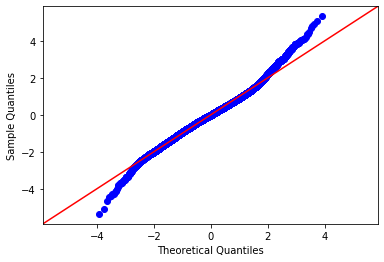

In [41]:
fig = sm.graphics.qqplot(results.resid, dist=stats.norm, line='45', fit=True)

In [42]:
final = final.drop(['floors'],axis=1)

final_model_R2 = np.mean(cross_val_score(linreg, final, y, scoring='r2', cv=crossval))

print(final_model_R2)

import statsmodels.api as sm
df_inter_sm = sm.add_constant(final)
model = sm.OLS(y,final)
results = model.fit()

results.summary()

0.7709538511967806


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.772
Model:                            OLS   Adj. R-squared:                  0.772
Method:                 Least Squares   F-statistic:                     3476.
Date:                Mon, 11 May 2020   Prob (F-statistic):               0.00
Time:                        16:42:43   Log-Likelihood:                 32087.
No. Observations:               21596   AIC:                        -6.413e+04
Df Residuals:                   21574   BIC:                        -6.395e+04
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                      1243.9335    134.648      9.238      0.000     980.013    1507.854
bedrooms                     -0.0076      0.001    -13.601      0.000      -0.009      -0.007
bathrooms                     0.0175      0.001     20.417      0.000       0.016       0.019
condition                     0.0118      0.001     18.653      0.000       0.011       0.013
grade                         0.0370      0.001     65.199      0.000       0.036       0.038
lat                         -26.0063      2.836     -9.169      0.000     -31.566     -20.447
long                        -10.3729      1.101     -9.424      0.000     -12.530      -8.216
sqft_basement_(109, 450]      0.0155      0.002      9.350      0.000       0.012       0.019
sqft_basement_(450, 980]      0.0127      0.002      5.845      0.000       0.008       0.017
sqft_basement_(980, 5000]     0.0247      0.003      8.349      0.000       0.019       0.030
date_log                      0.0169      0.001     13.089      0.000       0.014       0.019
sqft_living_log               0.1342      0.018      7.467      0.000       0.099       0.169
sqft_lot_log                  9.3774      2.922      3.209      0.001       3.649      15.105
sqft_above_log                0.1481      0.015      9.911      0.000       0.119       0.177
yr_built_log                 -0.0996      0.002    -46.829      0.000      -0.104      -0.095
sqft_living15_log             0.1648      0.005     31.250      0.000       0.154       0.175
sqft_lot15_log               17.4401      2.893      6.027      0.000      11.769      23.112
zipcode_log                 -40.4333      2.171    -18.622      0.000     -44.689     -36.177
lat*sqft_lot15_log           -0.3680      0.061     -6.048      0.000      -0.487      -0.249
lat*sqft_lot_log             -0.1968      0.061     -3.202      0.001      -0.317      -0.076
long*zipcode_log              0.3305      0.018     18.610      0.000       0.296       0.365
lat*long                      0.2169      0.023      9.353      0.000       0.171       0.262
==============================================================================
Omnibus:                      593.714   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1235.286
Skew:                           0.172   Prob(JB):                    5.77e-269
Kurtosis:                       4.120   Cond. No.                     2.10e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.1e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
# Test Errors Results
cv_5_results = cross_val_score(linreg, final, y, cv=5, scoring=mse)
cv_5_results


print(f"RMSE: {np.sqrt(cv_5_results.mean())}")

In [ ]:
abs(final.corr() > 0.75)

In [ ]:
#final = final.drop(['sqft_lot15_log','lat*sqft_lot15_log','sqft_lot_log*sqft_lot15_log'],axis=1)
#final = final.drop(['sqft_lot15_log','lat*sqft_lot15_log'],axis=1)
final = final.drop(['sqft_lot15_log','lat*sqft_lot15_log','sqft_lot_log*sqft_lot15_log'],axis=1)

final_model_R2 = np.mean(cross_val_score(linreg, final, y, scoring='r2', cv=crossval))

print(final_model_R2)

import statsmodels.api as sm
df_inter_sm = sm.add_constant(final)
model = sm.OLS(y,final)
results = model.fit()

results.summary()

In [ ]:
# Test Errors Results
cv_5_results = cross_val_score(linreg, final, y, cv=5, scoring=mse)
cv_5_results


print(f"RMSE: {np.sqrt(cv_5_results.mean())}")